In [22]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.patches as mpatches

## Adaptative Learning Agent

Similar approaches for enviroment changes detection: [ADWIN](https://riverml.xyz/0.21.0/api/drift/ADWIN/)


In [41]:
N_ROWS = 5
N_COLS = 5
GRID_WORLD = np.zeros((N_ROWS, N_COLS))

GAMMA = .8
ALPHA = 0.2
MIN_EPSILON = 0.03

In [146]:
class AdaptativeAgent():
    
    def __init__(self, initial_state, actions, world_knowledge, 
                 restart_states, decay_rate=0.06):
        self.step = 0
        self.time = 0
        self.current_reward = 0
        self.actions = actions
        self.restart_states = restart_states
        self.decay_rate = decay_rate
        self.adapt_flag = []
        self.initial_state = initial_state
        self.current_state = initial_state
        self.knowledge = {(i,j): {'short_memory':[]} for i in range(N_ROWS) for j in range(N_COLS)}
        self.world_knowledge = world_knowledge
                
    def __str__(self) -> str:
        return f'turti at {self.current_state} with knowledge {self.knowledge[self.current_state]}'
    
    def change_world_knowledge(self, state, value):
        self.world_knowledge[state] = value
    
    def get_next_state(self, base_state, next_action: str) -> tuple:
        if next_action == 'Up':
            new_state = (max(base_state[0] - 1, 0), base_state[1])
        elif next_action == 'Down':
            new_state = (min(base_state[0] + 1, N_ROWS - 1), base_state[1])
        elif next_action == 'Left':
            new_state = (base_state[0], max(base_state[1] - 1, 0))
        elif next_action == 'Right':
            new_state = (base_state[0], min(base_state[1] + 1, N_COLS - 1))
        return new_state
    
    def get_best_action(self, state):
        possible_actions = [a for a in self.actions if self.get_next_state(state, a) != state]
        random.shuffle(possible_actions)
        
        if not possible_actions:
            return None, 0
        
        # Obtener el valor mínimo conocido para las acciones posibles
        min_value = min([self.knowledge[state].get(a, 0) for a in possible_actions], default=0)
        
        # Ordenar las acciones por el valor Q estimado
        actions = sorted([(a, self.knowledge[state].get(a, min_value + 0.1 * min_value)) 
                          for a in possible_actions], 
                         key=lambda x: x[1], reverse=True)
        
        return actions[0]

    def calculate_next_action_reward(self, next_state, action):
        if next_state == self.current_state:
            return self.knowledge[self.current_state].get(action, 0)
        
        # Valor Q actual para la acción
        q_a_st = self.knowledge[self.current_state].get(action, 0)
        
        # Valor Q máximo en el siguiente estado
        _, q_max_a_st1 = self.get_best_action(next_state)
        
        # Actualización de Q-learning
        q = q_a_st + ALPHA * (self.world_knowledge[next_state] + GAMMA * q_max_a_st1 - q_a_st)
        
        return q
    
    def update_q_knowledge(self):
        for action in self.actions:
            next_state = self.get_next_state(self.current_state, action)
            if next_state == self.current_state:
                continue
            self.knowledge[self.current_state][action] = self.calculate_next_action_reward(next_state, action)
    
    def choose_greedy_action(self, epsilon):
        if random.random() < epsilon:
            return random.choice(self.actions)
        else:
            best_action, max_reward = self.get_best_action(self.current_state)
            self.knowledge[self.current_state]['short_memory'].append(max_reward)
            self.current_reward = max_reward
            
            return best_action
    
    def restart(self):
        self.current_state = self.initial_state
    
    def epsilon_decay(self, t):
        return MIN_EPSILON + (1 - MIN_EPSILON) * np.exp(-self.decay_rate * t)
    
    def handle_environment_change(self):
        self.knowledge = {(i,j): {'short_memory':[]} for i in range(N_ROWS) for j in range(N_COLS)}
        self.step = 0
        self.current_reward = 0
        self.adapt_flag.append(self.time)
    
    def move(self):
        self.update_q_knowledge()
        
        self.step += 1
        self.time += 1
        
        decay = self.epsilon_decay(self.step) 
        
        new_action = self.choose_greedy_action(epsilon=decay)
        
        new_state = self.get_next_state(self.current_state, new_action)
        
        self.current_state = new_state
        
        # Verificar la señal para olvidar y adaptar
        # last_steps_window as param
        last_rewards_window = 5
        last_rewards = self.knowledge[new_state]['short_memory'][-last_rewards_window:]
        if last_rewards:
            avg_r = np.mean(last_rewards[:last_rewards_window-1])
            # n of sigmas as parameter
            std_r = 3 * np.std(last_rewards[:last_rewards_window-1])
            # since wich number we consider we are exploiting
            if abs(last_rewards[-1] - avg_r) > std_r and decay < 0.2:
                print(last_rewards, decay, self.time)

                self.handle_environment_change()
                
                # how many exploration
                self.step = 0
        
        if new_state in self.restart_states:
        #if new_state == TARGET_POS1 or new_state == TARGET_POS2:
            self.restart()
            return self.initial_state
        
        return new_state

### Simulations

[7.968400005837511, 7.973908708285863, 7.982133306509782, 7.985187415521972, 7.405200932625035] 0.196883517908359 88


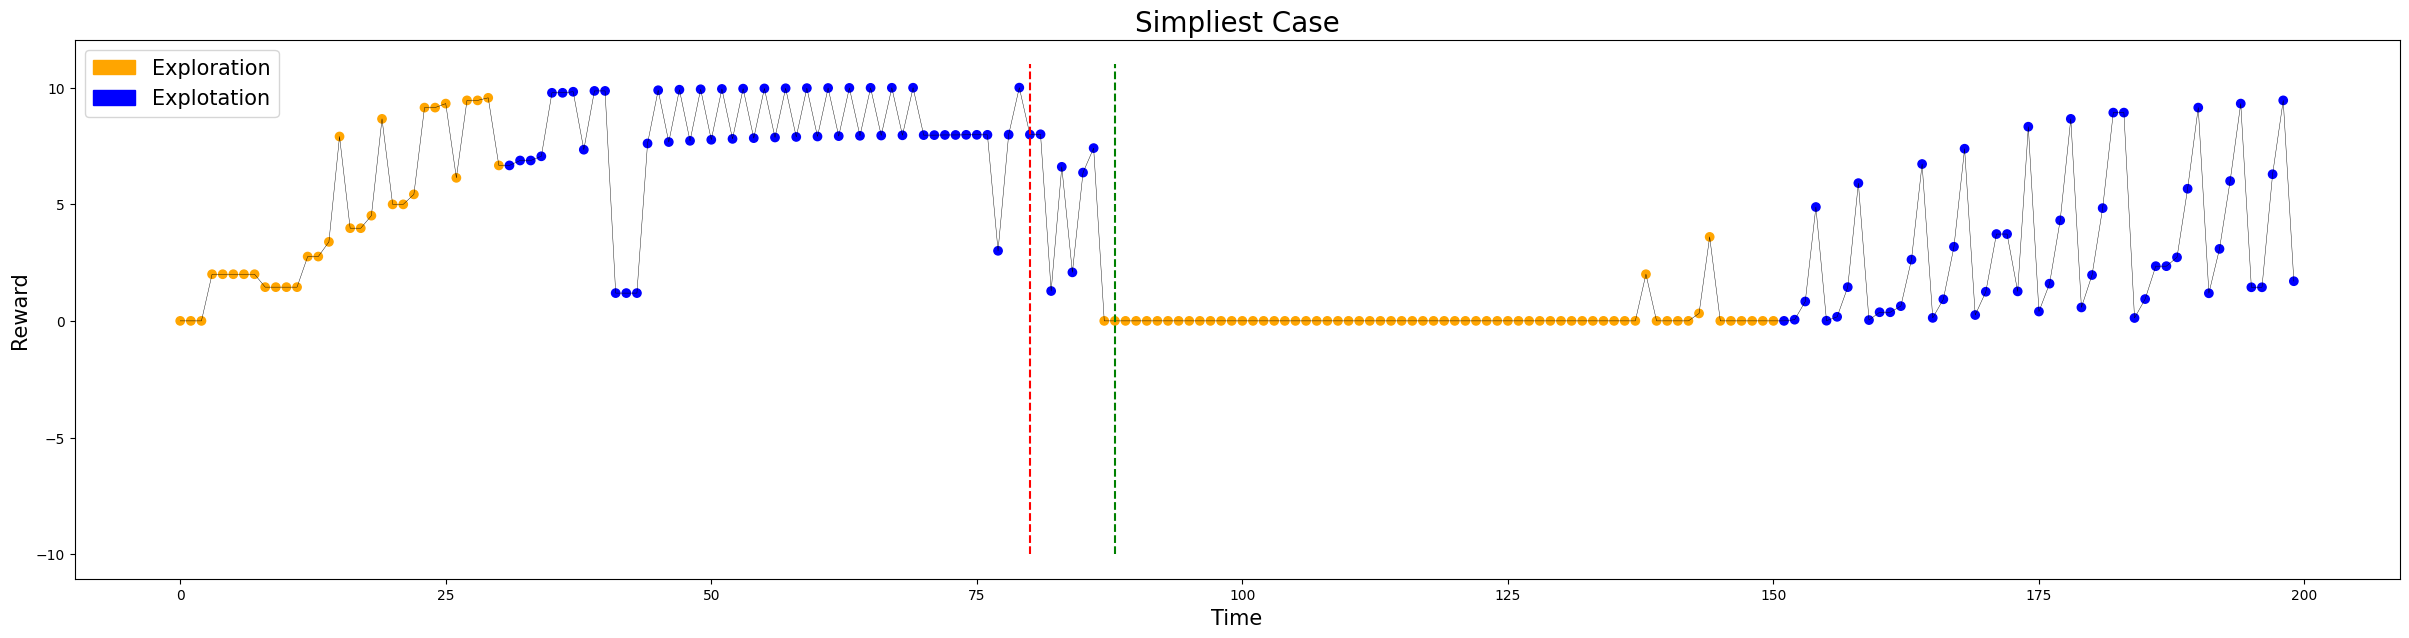

In [147]:
target_pos1 = (2,4)
target_pos2 = (2,0)

actions = ['Left', 'Right']

turti = AdaptativeAgent(initial_state=(2,2), 
                        actions=actions,
                        restart_states=[target_pos1, target_pos2],
                        decay_rate=0.04,
                        world_knowledge=GRID_WORLD.copy()
                        )

turti.world_knowledge[target_pos1] = 10
turti.world_knowledge[target_pos2] = -10

time = [t for t in range(200)]
moves = []
rewards = []

changing_times = [80, #300, 450
                  ]
for t in time:
       
    if t in changing_times:
        ori_actions_len = len(turti.actions)
        turti.actions.extend(['Up', 'Down'])
        new_actions_len = len(turti.actions)
        # Dynamic decay rate for the exploration according to the number of actions
        turti.decay_rate = turti.decay_rate/abs(ori_actions_len-new_actions_len)
        turti.change_world_knowledge(target_pos1, 0)
        turti.change_world_knowledge(target_pos2, 0)
        target_pos1 = (0,4)
        target_pos2 = (4,0)
        turti.restart_states = [target_pos1, target_pos2]
        turti.change_world_knowledge(target_pos1, -10)
        turti.change_world_knowledge(target_pos2, 10)
    
    pos_i = turti.current_state
    turti.move()
    pos_f = turti.current_state
    
    action = 'Explotation' if turti.epsilon_decay(turti.step)<0.3 else 'Exploration'
    
    try:
        reward_obtained = turti.current_reward
    except KeyError:
        reward_obtained = 0
    
    moves.append(action)
    rewards.append(reward_obtained)
    
    
plt.figure(figsize=(30,7))
plt.scatter(time, rewards, color = ['blue' if m=='Explotation' else 'orange' for m in moves])
plt.plot(time, rewards, linewidth=0.3, color='k')

for tc in changing_times:
    plt.vlines(x=tc, ymin=-10, ymax=11, color='r', linestyle='--')

for line in turti.adapt_flag:
    plt.vlines(x=line, ymin=-10, ymax=11, color='g', linestyle='--')
# Crear parches para la leyenda
blue_patch = mpatches.Patch(color='blue', label='Explotation',)
orange_patch = mpatches.Patch(color='orange', label='Exploration')

# Mostrar la leyenda
plt.legend(handles=[orange_patch, blue_patch], loc='upper left', fontsize=15)
plt.ylabel('Reward', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Simpliest Case', fontsize=20)
plt.show();

## Animation

[7.960962446235853, 7.9677558365085, 7.973393372822654, 7.978065661150806, 7.398142720801902] 0.196883517908359 88


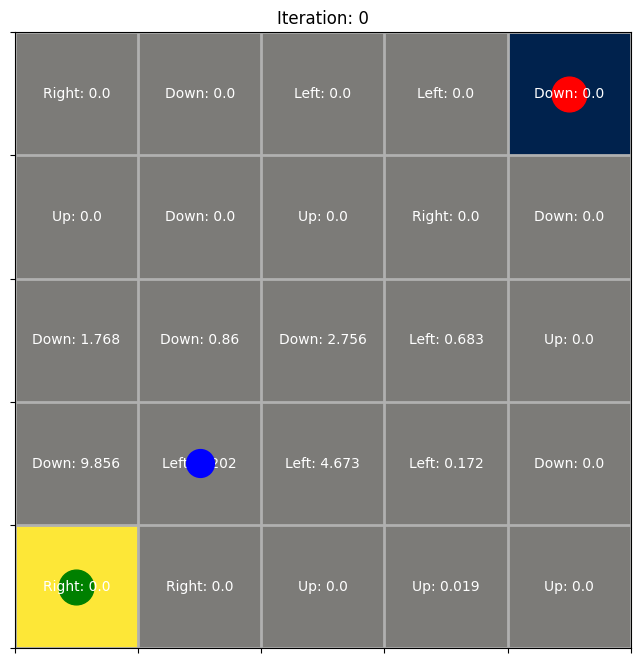

In [148]:
target_pos1 = (2,4)
target_pos2 = (2,0)

actions = ['Left', 'Right']

turti = AdaptativeAgent(initial_state=(2,2), 
                        actions=actions,
                        restart_states=[target_pos1, target_pos2],
                        decay_rate=0.04,
                        world_knowledge=GRID_WORLD.copy()
                        )

turti.world_knowledge[target_pos1] = 10
turti.world_knowledge[target_pos2] = -10

fig, ax = plt.subplots(figsize=(15, 8))

ct_1 = 80

def update(ite):
    global target_pos1, target_pos2
        
    if ite == ct_1:
        ori_actions_len = len(turti.actions)
        turti.actions.extend(['Up', 'Down'])
        new_actions_len = len(turti.actions)
        # Dynamic decay rate for the exploration according to the number of actions
        turti.decay_rate = turti.decay_rate/abs(ori_actions_len-new_actions_len)
        turti.change_world_knowledge(target_pos1, 0)
        turti.change_world_knowledge(target_pos2, 0)
        target_pos1 = (0,4)
        target_pos2 = (4,0)
        turti.restart_states = [target_pos1, target_pos2]
        turti.change_world_knowledge(target_pos1, -10)
        turti.change_world_knowledge(target_pos2, 10)
        
    world_knowledge = turti.world_knowledge.copy()
    ax.clear()
    ax.set_title(f'Iteration: {ite}')
    ax.imshow(world_knowledge, cmap='cividis')
    
    ax.set_xticks(np.arange(-.5, N_COLS, 1))
    ax.set_yticks(np.arange(-.5, N_ROWS, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.grid(which='both', linewidth=2)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    for i in range(world_knowledge.shape[0]):
        for j in range(world_knowledge.shape[1]):
            best_action, value = turti.get_best_action((i,j))
            ax.text(j, i, f'{best_action}: {round(value, 3)}', ha='center', va='center', color='white')        
    
    
    stage = 'blue' if turti.epsilon_decay(turti.step)<0.3 else 'orange'
    ax.plot(turti.current_state[1], turti.current_state[0], marker='o', markersize=20, color=stage, zorder=10000)
    
    
    symbol1 = 'go' if turti.world_knowledge[target_pos1] > 0 else 'ro'
    symbol2 = 'go' if turti.world_knowledge[target_pos2] > 0 else 'ro'
    
    ax.plot(target_pos1[1], target_pos1[0], symbol1, markersize=25)
    ax.plot(target_pos2[1], target_pos2[0], symbol2, markersize=25)
           
    
    if ite>0:
        turti.move()
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(200))
ani.save('simulations/q_learning_cl_actions.gif', fps=8)